C:\Users\Asia\miniconda3\envs\tensorflow\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[INFO] kompilowanie modelu...
[INFO] trenowanie...
Epoch 1/20
113/113 [==============================] - 148s 1s/step - loss: 0.3644 - accuracy: 0.8491 - val_loss: 0.1239 - val_accuracy: 0.9748
Epoch 2/20
113/113 [==============================] - 146s 1s/step - loss: 0.1105 - accuracy: 0.9640 - val_loss: 0.0739 - val_accuracy: 0.9835
Epoch 3/20
113/113 [==============================] - 151s 1s/step - loss: 0.0777 - accuracy: 0.9751 - val_loss: 0.0597 - val_accuracy: 0.9846
Epoch 4/20
113/113 [==============================] - 139s 1s/step - loss: 0.0621 - accuracy: 0.9776 - val_loss: 0.0532 - val_accuracy: 0.9868
Epoch 5/20
113/113 [==============================] - 138s 1s/step - loss: 0.0507 - accuracy: 0.9817 - val_loss: 0.0479 - val_accuracy: 0.9879
Epoch 6/20
113/113 [==============================] - 140s 1s/step - loss: 0.0524 - accuracy: 0.9826 - val_loss: 0.0454 - val_accuracy: 0.9879
Epoch 7/20
113/113 [==============================] - 163s 1s/step - loss: 0.0435 - accurac

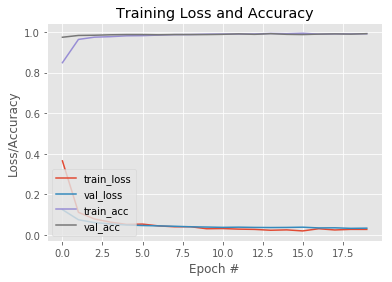

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


imagePaths = list(paths.list_images('dataset'))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#labels =lb.fit(labels).transform(labels)
labels = to_categorical(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

INIT_LR = 1e-4
EPOCHS = 20
BS = 32
print("[INFO] kompilowanie modelu...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] trenowanie...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS), steps_per_epoch=len(trainX) // BS, validation_data=(testX, testY), validation_steps=len(testX) // BS, epochs=EPOCHS)
N = EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

model.save('mask_recog_ver2.h5')